In [9]:
import cv2
import json
import folium
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from osmtogeojson import osmtogeojson

In [2]:
download = False

In [3]:
%%time
if download:
    # Should use [out:json] in the query as later osmtogeojson does not parse XML
    query = """[out:json][timeout:1000];
               wr["plant:source"="solar"];
               (._;>;);
               out;
            """
    req = requests.get("http://overpass-api.de/api/interpreter", params={'data': query})
    result = osmtogeojson.process_osm_json(req.json())

    with open("raw_osm_extract_01-10-2022.json", "w") as outfile:
        json.dump(result, outfile)
else:
    with open("raw_osm_extract_01-10-2022.json") as infile:
        result = json.load(infile)

CPU times: total: 844 ms
Wall time: 909 ms


In [4]:
%%time

# read in data in geopandas
gdf = gpd.GeoDataFrame.from_features(result, crs='epsg:4326', columns=['name', 'geometry'])
gdf = gdf[gdf.geometry.type == 'Polygon']
gdf['area_m'] = gdf.geometry.to_crs('epsg:3857').area.abs()
gdf

CPU times: total: 4.28 s
Wall time: 4.5 s


,name,geometry,area_m
0,Sunray - Solar Electric Generating Systems (Pl...,"POLYGON ((-116.82924 34.86980, -116.82148 34.8...",4.315022e+05
1,Solarpark Straßkirchen,"POLYGON ((12.74887 48.80562, 12.75227 48.80560...",7.416899e+05
2,Centrale solaire de Vignola,"POLYGON ((8.65386 41.91298, 8.65454 41.91295, ...",4.747284e+03
3,Centrale photovoltaïque des Monts,"POLYGON ((5.92809 45.57926, 5.92811 45.57923, ...",4.879371e+02
4,Centrale photovoltaïque de Saint-Aunès,"POLYGON ((3.97887 43.65232, 3.97886 43.65239, ...",1.637347e+04
...,...,...,...
26699,NaN,"POLYGON ((140.73642 38.11872, 140.73690 38.118...",2.964275e+04
26700,NaN,"POLYGON ((140.73795 38.11655, 140.73795 38.115...",3.097097e+03
26701,NaN,"POLYGON ((85.81354 47.49804, 85.80962 47.49795...",1.751617e+06
26702,Zonnepark Oppenhuizen,"POLYGON ((5.68849 53.01136, 5.69002 53.01214, ...",7.571903e+04


In [5]:
# display plygons on map
m = folium.Map((0, 0), zoom_start=3)
m.add_child(folium.GeoJson(gdf.sample(1000)))
m.add_child(folium.GeoJson(gdf.sort_values('area_m').tail(10), style_function=lambda x: {'color':'red'}))

## Coordinates to tiles

In [6]:
import numpy as np

def project(lat, lon):
    x = 0.5 + lon/360
    
    siny = np.sin((lat * np.pi)/180)
    siny = np.clip(siny, -0.9999, 0.9999)
    y = 0.5 - np.log((1+siny) / (1-siny)) / (4*np.pi)
    return x,y

def lat_lon_to_tile_vec(lat, lon, zoom):
    scale = 1<<zoom
    x, y = project(lat, lon) 
    return np.int_(x*scale), np.int_(y*scale)

def lat_lon_to_pixel_vec(lat, lon, zoom, relative=False):   
    scale = 1<<zoom
    x, y = project(lat, lon)    
    return np.int_(x*scale*256), np.int_(y*scale*256)


########################################################## Bounds to 
def bounds_to_tiles(xmin, ymin, xmax, ymax, zoom):
    lon, lat = np.meshgrid([xmin, xmax], [ymin, ymax])
    tiles_x, tiles_y = lat_lon_to_tile_vec(lat, lon, zoom)
    tiles_x = np.arange(np.min(tiles_x), np.max(tiles_x)+1)
    tiles_y = np.arange(np.min(tiles_y), np.max(tiles_y)+1)
    return tiles_x, tiles_y

def bounds_to_tile_tuples(xmin, ymin, xmax, ymax, zoom):
    tiles_x, tiles_y = bounds_to_tiles(xmin, ymin, xmax, ymax, zoom)
    return np.array(np.meshgrid(tiles_x, tiles_y)).T.reshape(-1, 2)   

In [7]:
# from IPython.display import Image
# import requests

# zoom = 17
# tiles = bounds_to_tile_tuples(*gdf.iloc[10].geometry.bounds, zoom)
# for x,y in tiles:
#     url = f'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={zoom}'
#     img = requests.get(url).content
#     display(Image(img))
    
#     url = f'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{zoom}/{y}/{x}'
#     img = requests.get(url).content
#     display(Image(img))

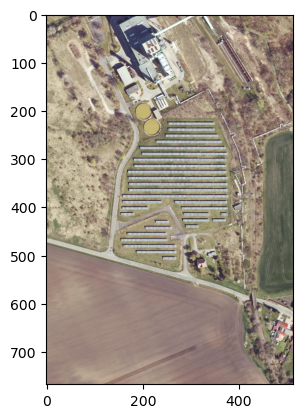

In [10]:
zoom = 17
tiles_x, tiles_y = bounds_to_tiles(*gdf.iloc[10].geometry.bounds, zoom)

img_x_stack = []
for x in tiles_x:
    img_y_stack = []
    for y in tiles_y:
        url = f'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{zoom}/{y}/{x}'
        img = requests.get(url).content
        # display(Image(img))
        nparr = np.frombuffer(img, np.uint8)
        rgb_img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        img_y_stack.append(rgb_img)
    
    img_y = cv2.vconcat(img_y_stack)
    img_x_stack.append(img_y)
    
img = cv2.hconcat(img_x_stack)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

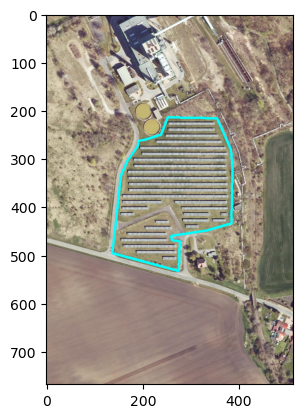

In [11]:
lon_coords, lat_coords = np.asarray(gdf.iloc[10].geometry.exterior.coords.xy)
pixel_x, pixel_y = lat_lon_to_pixel_vec(lat_coords, lon_coords, zoom)
                                    
pixel_x = pixel_x - (min(tiles_x) * 256)
pixel_y = pixel_y - (min(tiles_y) * 256)
poly_coords = np.c_[pixel_x, pixel_y]
poly_coords = poly_coords.reshape((-1,1,2))

test = cv2.polylines(img, [poly_coords], True, (0,255,255), thickness=3)
plt.imshow(test)
plt.show()

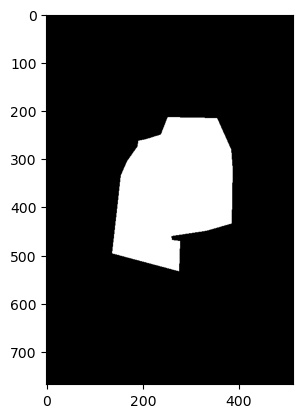

In [116]:
mask = cv2.fillPoly(np.zeros(img.shape[:2]), [poly_coords], color=255)
plt.imshow(mask, cmap='gray')
plt.show()

552


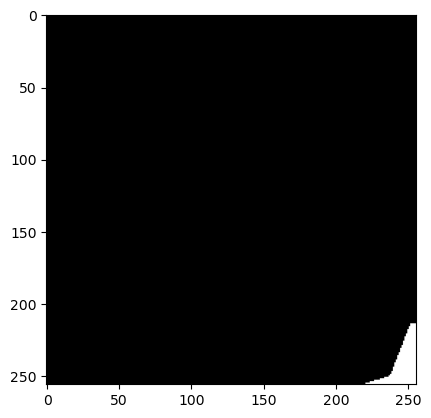

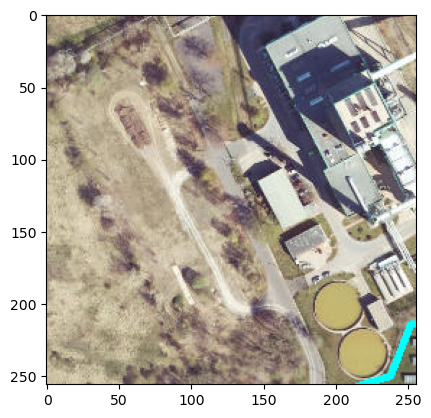

25434


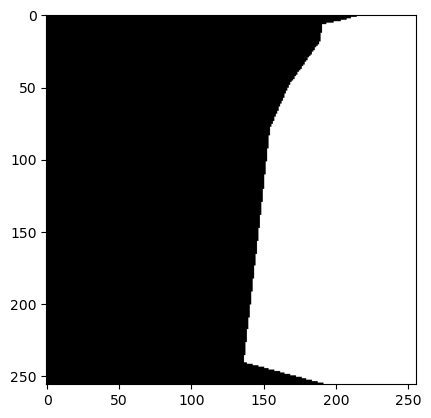

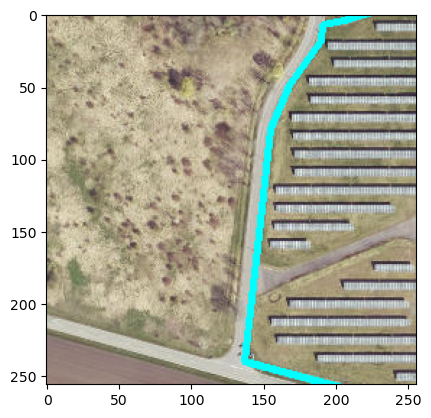

524


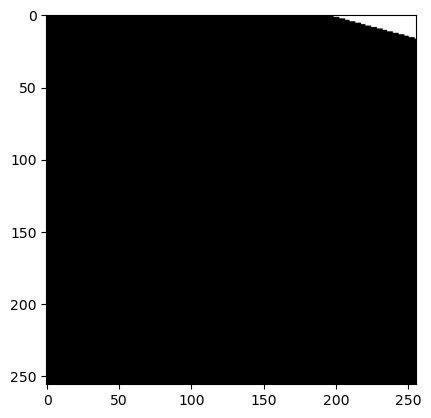

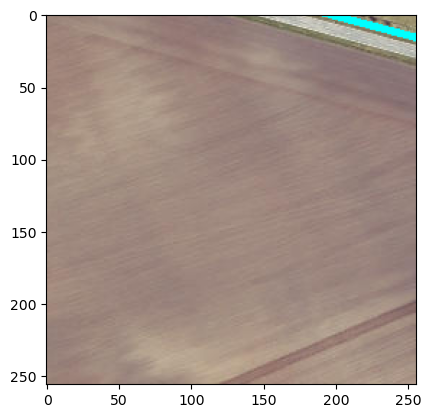

In [119]:
def img_spliter(image, x:'int - pixels'=256, y:'int - pixels'=256, color=True):
    return [image[y:y+256, x:x+256, :] if color else image[y:y+256, x:x+256]
                                            for x in range(0, image.shape[1], 256)
                                                for y in range(0, image.shape[0], 256)]
    
for a, b, _ in zip(img_spliter(mask, color=False), img_spliter(test), range(3)):
    plt.imshow(a, cmap='gray')
    plt.show()
    plt.imshow(b)
    plt.show()